# Task 7.1D Function Approximation Implementation
Christopher Abbey

Github repo: https://github.com/rissicay/acrobot-function-approx

This report will provide implementation of the the following methods:
- Semi-Gradient Sarsa(0)
- Semi-Gradient TD(Lambda)

We will implement both algorithms and then compare the similarity and differences of these algorithm. Semi-Gradient Sarsa will then be used to solve Acrobot-v1. Finally, compare these two algorithms, this includes there prupose, there similarities and there differences.

## Initialization

We are reusing the environment created in Task 3.1D. This environment we have exposed the raw state variables, instead of having the state variables being past into trig functions.

In [1]:
import gym
import numpy as np


env = gym.make('Acrobot-v1')

## State Aggregation

In Task 3.1D I had used tile coding, without knowing what tile coding was. This code is being reused, while the naming is different than what is typically used in tile coding, the principals are the same and I am very similar with the code. I have increased the state count slightly higher than Task 3.1, mainly because I could, the implementation of this task is more memory efficient than Task 3.1.


In [2]:
def find_point(value, increment):
    return round(round(value / increment) * increment, 2)

def approximate(raw_state):
    array = list(raw_state)
    return tuple([
        find_point(array[0], 0.2) + 0, 
        find_point(array[1], 0.2) + 0, 
        find_point(array[2], 0.2) + 0,
        find_point(array[3], 0.5) + 0
    ])

def generate(lower_bound, upper_bound, interval):
    output = [lower_bound]
    while lower_bound <= upper_bound:
        lower_bound += interval
        output.append( float( round(lower_bound,1) + 0 ) )
    return output

def generate_states(theta1, theta2, ang_vel_theta1, ang_vel_theta2):
    states = []
    has_zero = False
    for a in theta1:
        for b in theta2:
            for c in ang_vel_theta1:
                for d in ang_vel_theta2:
                    if a == 0.0 and b == 0.0 and c == 0.0 and d == 0.0:
                        has_zero = True
                    states.append((a, b, c, d))
                    
    if not has_zero:
        states.append((0.0, 0.0, 0.0, 0.0))
                    
    return states

In [3]:
from acrobot_env import *

env = AcrobotEnv()

theta1 = generate(-3.2, 3.2, 0.2)
theta2 = generate(-3.2, 3.2, 0.2)
ang_vel_theta1 = generate(-13, 13, 0.2)
ang_vel_theta2 = generate(-28.5, 28.5, 0.5)

states = generate_states(theta1, theta2, ang_vel_theta1, ang_vel_theta2)

mapping = {}
idx = 0
for state in states:
    mapping[state] = idx
    idx += 1
    
mapping_state_action = {}
idx = 0

actions = [0, 1, 2]

for state in states:
    for action in actions:
        mapping_state_action[(state, action)] = idx
        idx += 1

## Semi-Gradient TD(Lambda)

![Pseudocode for Semi-Gradient TD(Lambda)](img/td.png)

Semi-Gradient Td(Lambda) is a prediction algorithm, not a control algorithm. A prediction algorithm takes a policy and returns a value function. The policy we have selected to evaluation is a random policy. Since a value function is returned from this algorithm we can not use it to solve acrobot. It is possible to edit this algorithm to return a q function instead of a value function, this is a different algorithm though.

In [4]:
tolerance = 10**-8

class TDEstimator():
    
    def __init__(self, alpha=0.1, gamma=0.9, lamb=0.8):
        self.weights = np.zeros(len(mapping))
        self.z = np.zeros(len(mapping))
        self.alpha = alpha
        self.gamma = gamma
        self.lamb = lamb
        
    def featurize_state(self, state):
        point = approximate(state)
        idx = mapping[point]
        
        return idx
    
    def predict(self, state):
        
        idx = self.featurize_state(state)
        return self.weights[idx]
    
    def update_trace(self, state):
        dev = 1
        self.z *= self.gamma * self.lamb
        
        idx = self.featurize_state(state)
        self.z[idx] += dev
    
    def update(self, next_state, state, reward):
        delta = reward + self.gamma * self.predict(next_state) - self.predict(state)
        delta *= self.alpha
        self.weights += delta * self.z
        self.weights[np.isclose(self.weights, 0, atol=tolerance)] = 0 # to prevent stuff from overflowing
        

def get_random_action():
    return np.random.choice([0, 1, 2])

In [5]:
rewards_semi_grad_td = []

def semi_grad_td_policy_eval(env, episodes=100, alpha=0.1, gamma=0.9, lamb=0.8):
    print("start")
    estimator = TDEstimator(alpha=alpha, gamma=gamma, lamb=lamb)
    
    for e in range(episodes):
        reward_acc = 0
        state = env.reset()
        action = get_random_action()
        
        for t_ in range(10**100):
            next_state, reward, done, info = env.step(action)
            reward_acc += reward
            
            
            estimator.update_trace(state)
            estimator.update(state, next_state, reward)
            
            state = next_state
            
            if done:
                rewards_semi_grad_td.append(reward_acc)
                break
                
            action = get_random_action()
                
    return estimator


In [6]:
estimator = semi_grad_td_policy_eval(env, episodes=100)

start


## Semi-Gradient Sarsa(0)

![Pseudocode for Semi-Gradient Sarsa(0)](img/sarsa.png)

Semi-Gradient Sarsa is a control algorithm. This algorithm will generate an optimal policy that can be used to solve acrobot. The implement below is standard implementation. Since tile coding is used, the predict function for the estimator simplifies to just the weight.

In [7]:
def epsilon_greedy_action(state, q_estimator, eps=0.01):
    if np.random.rand() > eps:
        q_values = [q_estimator.predict(state,a) for a in actions]
        return argmax_rand(q_values)
    else:
        return np.random.choice(actions)

def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [8]:
class SarsaEstimator():
    """
    Linear action-value (q-value) function approximator for 
    semi-gradient methods with state-action featurization via tile coding. 
    """
    
    def __init__(self, alpha=0.1, gamma=0.9):
        
        self.weights = np.zeros(len(mapping_state_action))
        self.z = np.zeros(len(mapping_state_action))
        self.alpha = alpha
        self.gamma = gamma

        
    def featurize_state_action(self, state, action):
        point = approximate(state)
        idx = mapping_state_action[(point, action)]
        
        return idx
    
    def predict(self, s, a=None):
        return self.weights[self.featurize_state_action(s, a)]

        
            
    def update(self, s, a, target):
        features = self.featurize_state_action(s, a)
        estimation = np.sum(self.weights[features])
        delta = (target - estimation)
        
        self.weights += self.alpha * delta 

    

In [9]:
rewards_semi_grad_sarsa = []

def semi_grad_sarsa(env, episodes=100, alpha=0.1, gamma=0.9):

    estimator = SarsaEstimator(alpha=alpha, gamma=gamma)
    
    
    for e in range(episodes):
        rewards_acc = 0
        state = env.reset()
        action = epsilon_greedy_action(state, estimator)
        
        for t_ in range(10**100):
            state_next, reward, done, info = env.step(action)
            rewards_acc += reward
            
            
            if done:
                estimator.update(state, action, reward)
                rewards_semi_grad_sarsa.append(rewards_acc)
                break

                
            action_next = epsilon_greedy_action(state, estimator)
            target = reward + gamma * estimator.predict(state_next, action_next)
            estimator.update(state, action, target)
            state, action = state_next, action_next
                
    return estimator

In [10]:
estimator = semi_grad_sarsa(env)

In [11]:
policy = {}

for state in states:
    policy[state] = argmax_rand([estimator.predict(state,a) for a in actions])

In [14]:

rewards = []
for e in range(2):
    state = env.reset()
    reward = 0
    for t in range(10**100):
        point = approximate(state)
        action = policy[point]
        state, r, done, _ = env.step(action)  # Take step
        env.render()  # Animate
        reward += r
        if done:
            print('Solved in {} steps'.format(t))
            rewards.append(reward)
            break

Solved in 1188 steps
Solved in 2390 steps


## Semi-Gradient Sarsa(0) Performance

Like in Task 3.1, the policy produced is capable of solving acrobot. The average number of steps to complete acrobot is worst than the policy we produced in Task 3.1, even with more states. The big difference between Task 3.1 and Task 7.1 is the amount of training time required, Task 7.1 was significantly faster. To train the policy in Task 7.1 too multiple hours, on the other hand, Task 3.1 required me to run the algorithm overnight.

It is of my opinion that we could match the performacne of Task 3.1 by increasing the episode we train for. 

<Figure size 432x288 with 0 Axes>

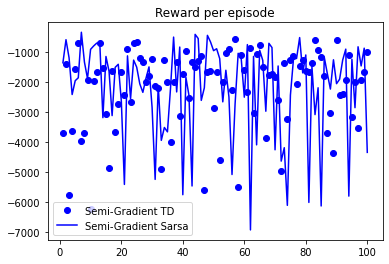

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

episodes = range(1, len(rewards_semi_grad_sarsa) + 1)

plt.plot(episodes, rewards_semi_grad_td, 'bo', label='Semi-Gradient TD')
plt.plot(episodes, rewards_semi_grad_sarsa, 'b', label='Semi-Gradient Sarsa')
plt.title('Reward per episode')
plt.legend()

plt.figure()

## Comparison of Rewards

From the chart above, we can see there is not much difference between the two algorithm. Semi-Gradient TD is expected to have a random distribution as can be seen above, this is because we are using a random policy, the rewards should vary from episode to episode, depending on how lucky you get. Semi-Gradient Lambda is a bit of a surprise though, the expectation is that rewards should improve in line with number of episodes, we don't see this.

Multiple things could have caused this error, my theory is that during the multiple runs, sarsa had pretrained weights with the final model I am using to write my report. As the model takes 4-5 hours to train, I can not try to resolve this.

## Comparison between Semi-Gradient TD(Lambda) and Semi-Gradient Sarsa(0)

The biggest difference between Semi-Gradient TD and Semi-Gradient Sarsa is that one algorithm is a prediction algorithm and the other algorithm is a control algorithm. In a way comparing these two algorthims is like comparing apples and oranges. A prediction algorithm purpose is to take a policy and to return a value function. These algorithm can be used for purposes such as policy evaluation. A control policy purpose is to return an optimal policy. An optimal policy can then be used to solve a problem, such as acrobot.

Another difference between these algorithms is the use of bootstrapping. TD uses an eligibility trace, which in a way is a form of bootstrapping, Sarsa does not. Theorectically this should allow training to happen faster. This could not be tested in this report.